# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob
import h5py 
import ray
import logging 
import json
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import xarray as xr
import scipy.linalg as linalg
import scipy.sparse as sparse
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

from tqdm.auto import tqdm, trange
from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
from pathlib import Path
from scipy.optimize import minimize_scalar,minimize
from scipy.interpolate import interp1d
from scipy.ndimage import shift as imshift
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn import linear_model as lm 
from scipy.stats import binned_statistic
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_poisson_deviance
from pyglmnet import GLMCV, GLM

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append('/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/')
sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *

pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:40182',
 'object_store_address': '/tmp/ray/session_2021-10-28_22-11-01_171077_970727/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-28_22-11-01_171077_970727/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/tmp/ray/session_2021-10-28_22-11-01_171077_970727',
 'metrics_export_port': 51433,
 'node_id': 'ad02e5ba9ae36ca83d69815390daa07f4708a0c4affb0e3f96ef7dc9'}

In [2]:
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn' # 'fm1' # 
# 012821/EE8P6LT
# 128: 070921/J553RT
date_ani = '070921/J553RT' #'062921/G6HCK1ALTRN'
data_dir  = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type
save_dir  = check_path(Path('~/Research/SensoryMotorPred_Data/data/').expanduser() / date_ani, stim_type)
FigPath = check_path(Path('~/Research/SensoryMotorPred_Data').expanduser(),'Figures/Decoding')
FigPath = check_path(FigPath/date_ani, stim_type)
FigPath_SFN = check_path(FigPath,'SFN')

print('save_dir:',save_dir)
print('data_dir:',data_dir)
print('FigPath:', FigPath)
# with open(save_dir / 'file_dict.json','r') as fp:
#     file_dict = json.load(fp)

save_dir: /home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1
data_dir: /home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1
FigPath: /home/seuss/Research/SensoryMotorPred_Data/Figures/Decoding/070921/J553RT/fm1


In [3]:
file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type=='fm1' else None,
            'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
            'mp4': True,
            'name': '01221_EE8P6LT_control_Rig2_'+stim_type, #070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type=='hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type=='fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(),}

In [4]:
model_dt = .05
do_shuffle=False
do_norm = False
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=do_norm,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

lag_list = np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'Pytorch'
ncells=model_nsp.shape[-1]
bin_length=40


Done Loading Aligned Data
TRAIN: 15628 TEST: 6698
[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]


In [5]:
lag_list = np.array([0]) #-2,-1,0,1,2]) 
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle = False
model_type = 'Pytorch'

# for do_shuffle in [False,True]:
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
if free_move:
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) 
    model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis]))
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)
    move_train = move_train - np.mean(move_train,axis=0)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
n=4; ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))

##### Start GLM Parallel Processing #####
# Reshape data (video) into (T*n)xN array
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
rolled_vid_flat = rolled_vid.reshape(rolled_vid.shape[0],-1)
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)


[0] [0.]
Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


In [ ]:
for epoch in Nepochs:


In [20]:
class Decoding_Network(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, hidden_layers=2, device='cuda'):
        super(Decoding_Network, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.relu = nn.ReLU()
        self.input_layer = nn.Linear(self.in_features,self.out_features)
        self.layers = []
        for n in range(hidden_layers):
            self.layers.append(nn.Linear(self.hidden_features,hidden_features))
        self.out_layer = nn.Linear(self.hidden_features,self.out_features)

    def forward(self, inputs, move_input=None):
        x, y = inputs.shape
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        output = inputs.matmul(self.weight.t())
        if move_input != None:
            output = output + move_input.matmul(self.move_weights.t())
        if self.bias is not None:
            output = output + self.bias
        ret = torch.log1p(torch.exp(output))
        return ret
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
    def loss(self,Yhat, Y): 
        if self.move_features != None:
#             l2_reg = self.lam*(torch.linalg.norm(self.weight[:,:-self.move_features],axis=1,ord=2))
#             l1_reg = self.alpha*(torch.linalg.norm(self.weight[:,:-self.move_features],axis=1,ord=1))
#             l2_regm = self.lam_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=2))
            if self.reg_alph != None:
                l1_regm = self.alpha_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=1))
                l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
            else: 
                l1_regm = 0
                l1_reg = 0
            loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l1_reg + l1_regm
        else:
            if self.reg_lam != None:
                if self.reg_alph != None:
                    l2_reg = self.lam*(torch.linalg.norm(self.weight,axis=1,ord=2))
                    l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l2_reg + l1_reg
                else:
                    l2_reg = self.lam*(torch.linalg.norm(self.weight,axis=1,ord=2)) 
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l2_reg
            else:
                if self.reg_alph != None:
                    l1_reg = self.alpha*(torch.linalg.norm(self.weight,axis=1,ord=1))
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0) + l1_reg
                else:
                    loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0)
        return loss_vec


(torch.Size([15628, 600]), (15628, 128))

In [25]:
dataset_tr = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(train_nsp).float())
dataloader_tr = DataLoader(dataset_tr,batch_size=x_train.shape[0])
dataset_te = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(test_nsp).float())
dataloader_te = DataLoader(dataset_te,batch_size=x_test.shape[0])

In [26]:

MovModel = 1
# Reshape data (video) into (T*n)xN array
if MovModel == 0:
    mx_train = move_train[:,perms[ind]]
    mx_test = move_test[:,perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)    
    move_features = None # mx_train.shape[-1]
    nk = 0
    xtrm = None
    xtem = None
elif MovModel == 1:
    x_train_m1 = (rolled_vid[train_idx].reshape(len(train_idx),-1)).astype(np.float32)
    x_test_m1 = (rolled_vid[test_idx].reshape(len(test_idx),-1)).astype(np.float32)
    xtr = torch.from_numpy(x_train_m1).to(device)
    xte = torch.from_numpy(x_test_m1).to(device)
    move_features = None
    xtrm = None
    xtem = None
elif MovModel == 2:
    xtrm = torch.from_numpy(move_train[:,perms[ind]].astype(np.float32)).to(device)
    xtem = torch.from_numpy(move_test[:,perms[ind]].astype(np.float32)).to(device)
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    move_features = xtrm.shape[-1]
elif MovModel == 3:
    x_train_m3 = np.hstack((np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
    x_test_m3 = np.hstack((np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    xtrm = torch.from_numpy(x_train_m3.astype(np.float32)).to(device)
    xtem = torch.from_numpy(x_test_m3.astype(np.float32)).to(device)
    move_features = x_train_m3.shape[-1]

    
ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)
input_size = xtr.shape[1]
output_size = ytr.shape[1]
print('Model: {}, move_features: {}'.format(MovModel, move_features))


Model: 1, move_features: None


In [ ]:

# lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')

Nbatches = 20000
if move_features != None:
    reg_params = np.zeros((Nbatches,output_size,4))
    reg_titles = ['lambda','lambda_m','alpha','alpha_m']
else:
    reg_params = np.zeros((Nbatches,output_size,2))
    reg_titles = ['lambda','alpha']


if MovModel == 0:
    sta_init = None
    lambdas = [0]#(2**(np.arange(0,10)))
    nlam = len(lambdas)
    alphas = [0]#np.array([.005,.01,.02]) #np.arange(.01,.5,.05)
    nalph = len(alphas)
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, input_size))
elif MovModel == 1:
    lambdas = (2**(np.arange(0,10)))/100
    nlam = len(lambdas)
    alphas = np.array([.0075]) #np.arange(.01,.5,.05)
    nalph = len(alphas)
    sta_init = torch.from_numpy(((rolled_vid_flat.T@model_nsp)/(10*np.sum(model_nsp,axis=0))).T.astype(np.float32))
elif MovModel == 2:
    lambdas = (2**(np.arange(0,10)))/100
    lambdas_m = (2**(np.arange(0, 10)))/10
    nlam = len(lambdas)
    alphas = np.array([.0075,]) #np.arange(.01,.5,.05) .005,.01,.02
    nalph = len(alphas)
    sta_init = torch.from_numpy(((rolled_vid_flat.T@model_nsp)/(10*np.sum(model_nsp,axis=0))).T.astype(np.float32))
    w_move_cv = np.zeros((nalph,nlam,output_size,move_features))
    w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, move_features))
else:
    lambdas = (2**(np.arange(0, 10)))
    lambdas_m = (2**(np.arange(0, 10)))
    nlam = len(lambdas)
    alphas = np.array([.01])  # np.arange(.01,.5,.05) .005,.01,.02
    nalph = len(alphas)
    sta_init = torch.from_numpy(((rolled_vid_flat.T@model_nsp)/(10*np.sum(model_nsp, axis=0))).T.astype(np.float32))
    w_move_cv = np.zeros((nalph, nlam, output_size, move_features), dtype=np.float32)
    # w_move_traces_all = np.zeros((nalph, nlam, Nbatches, output_size, move_features),dtype=np.float32)

#     sta_init = torch.from_numpy(np.hstack((((rolled_vid_flat.T@model_nsp)/(10*np.sum(model_nsp,axis=0))).T,np.zeros((output_size,move_features)))).astype(np.float32))
meanbias = torch.log(torch.exp(torch.mean(torch.tensor(model_nsp,dtype=torch.float32),axis=0)) - 1)

msetrain = np.zeros((nalph,nlam,output_size))
msetest = np.zeros((nalph,nlam,output_size))
pred_cv = np.zeros((x_test.shape[0],nalph,nlam,output_size),dtype=np.float32)
w_cv = np.zeros((x_train.shape[-1],nalph,nlam,output_size),dtype=np.float32)
bias_cv = np.zeros((nalph,nlam,output_size),dtype=np.float32)
tloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
vloss_trace_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)
bias_traces_all = np.zeros((nalph, nlam, Nbatches, output_size),dtype=np.float32)

lr_w = [1e-6, 1e-4]
lr_b = [1e-5, 5e-3]
lr_m = [1e-5, 1e-3]
start = time.time()
for a, reg_alph in enumerate(tqdm(alphas)):
    for l, reg_lam in enumerate(tqdm(lambdas)):
#         params = add_weight_decay(l1,lambdas[l])
#         optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':5e-5,'weight_decay':lambdas[l]}, {'params': [l1.bias],'lr':1e-3}], lr=5e-5) #'weight_decay':lambdas[l]
        if MovModel == 0: 
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=None,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr': 1e-3,},
                                           {'params': [l1.bias],'lr':lr_b[1]},], lr=5e-5) #
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_m[0],lr_b[0]], max_lr=[lr_m[1],lr_b[1]], cycle_momentum=False)
        elif MovModel == 1:
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                           {'params': [l1.bias],'lr':lr_b[1]},], lr=5e-5) #
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0]], max_lr=[lr_w[1],lr_b[1]], cycle_momentum=False)
        else:
            l1 = PoissonGLM_VM_staticreg(input_size,output_size,reg_lam=None,reg_alph=reg_alph,move_features=move_features,meanfr=meanbias,init_sta=sta_init,device=device).to(device)
            optimizer = optim.ASGD(params=[{'params': [l1.weight],'lr':lr_w[1],'weight_decay':lambdas[l]},
                                           {'params': [l1.bias],'lr':lr_b[1]},
                                           {'params': [l1.move_weights],'lr':1e-3, 'weight_decay': lambdas_m[l]}], lr=5e-5) #
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[lr_w[0],lr_b[0],lr_m[0]], max_lr=[lr_w[1],lr_b[1],lr_m[1]], cycle_momentum=False)
#         scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[1e-6,1e-5], max_lr=[1e-4,5e-3], cycle_momentum=False)
        early_stopping = EarlyStopping(patience=1000,min_delta=.005)

        vloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)      
        tloss_trace = np.zeros((Nbatches,output_size),dtype=np.float32)
        for batchn in np.arange(Nbatches):
            out = l1(xtr,xtrm)
            loss = l1.loss(out,ytr)
            pred = l1(xte,xtem)
            val_loss = l1.loss(pred,yte)
            vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
            tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
            bias_traces_all[a,l,batchn] = l1.bias.clone().cpu().detach().numpy()
            # if MovModel == 0:
            #     w_move_traces_all[a,l,batchn] = l1.weight.clone().cpu().detach().numpy()  # [:,(nk):]
            # elif MovModel != 1:
            #     w_move_traces_all[a,l,batchn] = l1.move_weights.clone().cpu().detach().numpy()  # [:,(nk):]
            optimizer.zero_grad()
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            scheduler.step()
            #     lam_grad[batchn]= l1.lam.grad.detach().cpu().numpy()
            early_stopping(np.mean(val_loss.clone().cpu().detach().numpy()))
#             if early_stopping.early_stop:
#                 break
        tloss_trace_all[a,l] = tloss_trace
        vloss_trace_all[a,l] = vloss_trace
        bias_cv[a,l] = l1.bias.clone().cpu().detach().numpy()
        if MovModel != 0:
            w_cv[:,a,l] = l1.weight.clone().cpu().detach().numpy().T #[:,:(nk)]
        if MovModel == 0: 
            w_move_cv[a,l] = l1.weight.clone().cpu().detach().numpy()#[:,(nk):]
        elif MovModel != 1:
            w_move_cv[a,l] = l1.move_weights.clone().cpu().detach().numpy()#[:,(nk):]
        pred =  l1(xte,xtem)
        msetest[a,l] = torch.mean(pred-yte*torch.log(pred),axis=0).cpu().detach().numpy()
        pred_cv[:,a,l] = pred.detach().cpu().numpy().squeeze()
  
print('GLM: ', time.time()-start)
# pred_all = l1(xte).cpu().detach().numpy()
if MovModel != 0:
    w_cv2 = w_cv.T.reshape((output_size,nlam,nalph,nt_glm_lag,)+nks)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

GLM:  513.058262348175


In [ ]:
malph,mlam,cellnum  = np.where(msetest==np.nanmin(msetest,axis=(0,1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum,return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]
sta_all = w_cv[:,malph,mlam,cellnum].T.reshape((output_size,nt_glm_lag,)+nks)
pred_all = pred_cv[:,malph,mlam,cellnum]
bias_all = bias_cv[malph,mlam,cellnum]
tloss_trace_all2 = tloss_trace_all[malph,mlam,:,cellnum]
vloss_trace_all2 = vloss_trace_all[malph,mlam,:,cellnum]
# w_move_traces = w_move_traces_all[malph, mlam, :, cellnum]
bias_traces = bias_traces_all[malph, mlam, :, cellnum]
if MovModel != 1:
    w_move = w_move_cv[malph,mlam,cellnum]

bin_length=40
r2_all = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2


In [ ]:
mlam

array([0, 0, 0, 9, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 9, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 5, 0])

In [ ]:

if MovModel == 0:
    GLM_Data = {'r2_all': r2_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all, 
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'w_move': w_move}
elif MovModel == 1:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
               }
else:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'test_nsp': test_nsp,
                'pred_all': pred_all,
                'bias_all': bias_all,
                'tloss_trace_all':tloss_trace_all2,
                'vloss_trace_all':vloss_trace_all2,
                'w_move': w_move}

if do_shuffle:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
else:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
ioh5.save(save_datafile, GLM_Data)
print(save_datafile)

/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_Data_VisMov_dt050_T05_MovModel1.h5


# SK Learn Lin Decoding

## Decoding Movement

Decoding of movement when only taking a quartile of the data that is most aligned with the rfs. Take dot prodcut of th frames with Rfs. 

In [96]:
model_type = 'ridgecv'
if model_type == 'elasticnetcv':
    model =lm.ElasticNetCV() # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
elif model_type == 'ridgecv':
    model = lm.RidgeCV()
    
clrs = ['blue','orange','green','red']

model.fit(train_nsp, move_train)
pred_train = model.predict(train_nsp)
pred_test = model.predict(test_nsp)
train_score = model.score(train_nsp,move_train)
test_score = model.score(test_nsp, move_test)
print('Train Score:', train_score, 'Test Score:', test_score)
# print(model['model_type'].coef_[22])
cc = np.corrcoef(pred_test,move_test)

move_w = model.coef_
r2_mov = np.zeros(len(titles))
for modeln in np.arange(len(titles)):
    r2_mov[modeln] = np.corrcoef(pred_test[:,modeln],move_test[:,modeln])[0,1]**2

Train Score: 0.1959744168247349 Test Score: 0.15753270537016914
cc=0.49


In [97]:
dataset_type = 'test'

if dataset_type == 'train':
    nsp_raw = train_nsp.copy()
    pred_data = pred_train.copy()
    move_data = move_train.copy()
    vid_data  = x_train.reshape((x_train.shape[0],) + nks)
    vid_data_fl  = x_train.copy()
else:
    nsp_raw = test_nsp.copy()
    pred_data = pred_test.copy()
    move_data = move_test.copy()
    vid_data  = x_test.reshape((x_test.shape[0],) + nks)
    vid_data_fl  = x_test.copy()

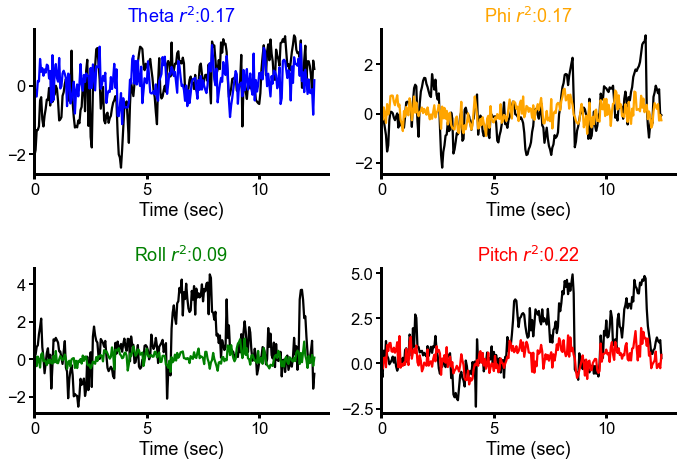

In [209]:
modeln = 0
t=800
dt=250
time_range = (np.arange(0,pred_data.shape[0])*model_dt)[0:dt]

fig, axs = plt.subplots(2,2,figsize=(10,7))
for (ax,modeln) in zip(axs.flat,range(len(titles))):
    ax.plot(time_range,pred_data[t:t+dt,modeln], c=clrs[modeln], zorder=1)
    ax.plot(time_range,move_data[t:t+dt,modeln],'k', zorder=0)
    ax.set_title(titles[modeln] + ' $r^2$:{:.02f}'.format(r2_mov[modeln]),color=clrs[modeln])
    ax.set_xlabel('Time (sec)')
    ax.set_xlim(left=0)
plt.tight_layout()
fig.savefig(FigPath/'Decoding_PredMov.png', facecolor='white', transparent=True, bbox_inches='tight',dpi=300)

## Decoding Vision

In [211]:
lambdas = (2**(np.arange(0,10)))

model_type = 'ridgecv'
if model_type == 'elasticnetcv':
    model =lm.ElasticNetCV() # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
elif model_type == 'ridgecv':
    model = lm.RidgeCV(alphas=lambdas)
    
clrs = ['blue','orange','green','red']

model.fit(train_nsp, x_train)
pred_train = model.predict(train_nsp)
pred_test = model.predict(test_nsp)
train_score = model.score(train_nsp,x_train)
test_score = model.score(test_nsp, x_test)
print('Train Score:', train_score, 'Test Score:', test_score)
# print(model['model_type'].coef_[22])

cc = np.corrcoef(pred_test,x_test)
print('cc={:.02f}'.format(cc[0,1]**2))
# pred_test = pred_test.reshape((pred_test.shape[0],)+nks)
vis_w = model.coef_

Train Score: 0.08975787219533193 Test Score: 0.056471078384780264
cc=0.55


In [212]:
dataset_type = 'test'

if dataset_type == 'train':
    nsp_raw = train_nsp.copy()
    pred_data_fl = pred_train.copy()
    pred_data = pred_train.reshape((x_train.shape[0],) + nks)
    move_data = move_train.copy()
    vid_data  = x_train.reshape((x_train.shape[0],) + nks)
    vid_data_fl  = x_train.copy()
else:
    nsp_raw = test_nsp.copy()
    pred_data_fl = pred_test.copy()
    pred_data = pred_test.reshape((x_test.shape[0],) + nks)
    move_data = move_test.copy()
    vid_data  = x_test.reshape((x_test.shape[0],) + nks)
    vid_data_fl  = x_test.copy()

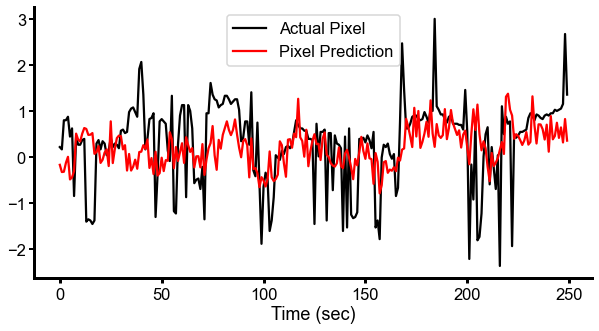

In [226]:
t=0
dt=250
time_range = (np.arange(0,pred_data.shape[0])*model_dt)[0:dt]
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(vid_data_fl[t:t+dt,np.argmax(r2_map_te)],c='k',label='Actual Pixel ')
ax.plot(pred_data_fl[t:t+dt,np.argmax(r2_map_te)],c='r',label='Pixel Prediction')
ax.set_xlabel('Time (sec)')
ax.legend()
fig.savefig(FigPath/'Decoding_singlepixel.png', facecolor='white', transparent=True, bbox_inches='tight',dpi=300)

In [213]:
r2_map_tr = np.zeros(pred_train.shape[1])
for n in np.arange(pred_train.shape[1]):
    r2_map_tr[n] = np.corrcoef(pred_train[:,n],x_train[:,n])[0,1]**2
    
r2_map_te = np.zeros(pred_test.shape[1])
for n in np.arange(pred_test.shape[1]):
    r2_map_te[n] = np.corrcoef(pred_test[:,n],x_test[:,n])[0,1]**2

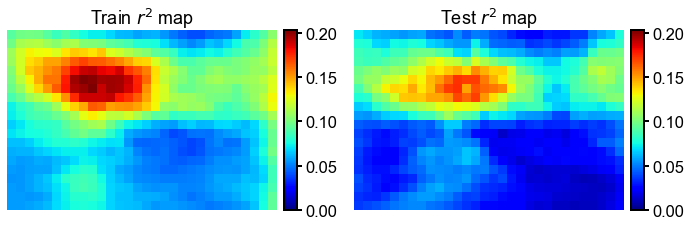

In [76]:
crange = np.max(np.abs((r2_map_tr,r2_map_te)))
fig, axs = plt.subplots(1,2,figsize=(10,5))
im = axs[0].imshow(r2_map_tr.reshape(nks),cmap='jet',vmin=0,vmax=crange)
cbar = add_colorbar(im)
axs[0].set_title('Train $r^2$ map')
im = axs[1].imshow(r2_map_te.reshape(nks),cmap='jet',vmin=0,vmax=crange)
cbar = add_colorbar(im)
axs[1].set_title('Test $r^2$ map')

for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
fig.savefig(FigPath/'R2_decodingmaps.png', facecolor='white', transparent=True, bbox_inches='tight',dpi=300)

In [77]:
sf = 4
vid_data_up = np.zeros((vid_data.shape[0],sf*vid_data.shape[-2], sf*vid_data.shape[-1]))
pred_data_up = np.zeros((vid_data.shape[0],sf*vid_data.shape[-2], sf*vid_data.shape[-1]))
for n in range(vid_data.shape[0]):
    vid_data_up[n] = cv2.resize(vid_data[n], (sf*vid_data.shape[-1], sf*vid_data.shape[-2]))
    pred_data_up[n] = cv2.resize(pred_data[n], (sf*pred_data.shape[-1], sf*pred_data.shape[-2]))


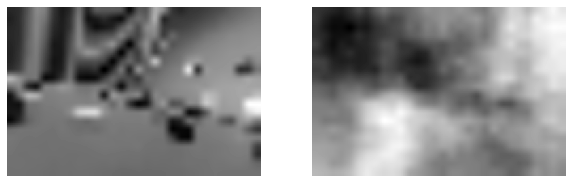

In [78]:
fm=100
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(vid_data_up[fm],cmap='gray')
axs[1].imshow(pred_data_up[fm],cmap='gray')

for ax in axs.flat:
    ax.axis('off')

In [79]:
max_visw = vis_w[np.argmax(r2_map_te)]
vis_w.shape

(600, 128)

## Coding Space Overlap

In [107]:
move_ang = np.zeros((vis_w.shape[0],len(titles)))
movmov_ang = np.zeros((len(titles),len(titles)))
V =  np.zeros((vis_w.shape[0],len(titles),2))
for pixn in np.arange(vis_w.shape[0]):
    for modeln in range(len(titles)):
        move_ang[pixn,modeln] = np.arccos(np.dot(vis_w[pixn],move_w[modeln])/(np.linalg.norm(vis_w[pixn])*np.linalg.norm(move_w[modeln])))
        V[pixn, modeln] = [np.cos(move_ang[pixn,modeln]),np.sin(move_ang[pixn,modeln])]
for modeln in range(len(titles)):
    for modeln2 in range(len(titles)):
        movmov_ang[modeln,modeln2] = np.arccos(np.dot(move_w[modeln],move_w[modeln2])/(np.linalg.norm(move_w[modeln])*np.linalg.norm(move_w[modeln2])))

In [ ]:
for modeln in np.arange(len(titles)):
    ax.plot()

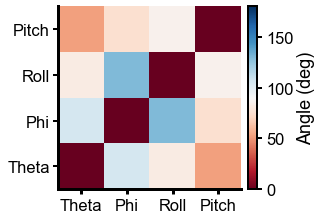

In [145]:
fig, ax, = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rad2deg(movmov_ang), cmap='RdBu',vmin=0,vmax=180,origin='lower')
cbar = add_colorbar(im)
cbar.set_label('Angle (deg)')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(titles)
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(titles)
plt.tight_layout()
fig.savefig(FigPath/'CodingSpace_MovMov.png', facecolor='white', transparent=True, bbox_inches='tight',dpi=300)

In [180]:
r2_movmov = np.zeros((4,4))
for modeln in range(4):
    for modeln2 in range(4):
        r2_movmov[modeln,modeln2] = np.corrcoef(move_w[modeln],move_w[modeln2])[0,1]**2 

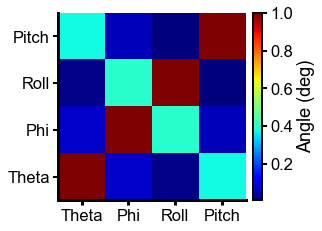

In [183]:
fig, ax, = plt.subplots(figsize=(5,5))
im = ax.imshow(r2_movmov, cmap='jet',origin='lower')
cbar = add_colorbar(im)
cbar.set_label('Angle (deg)')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(titles)
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(titles)
plt.tight_layout()

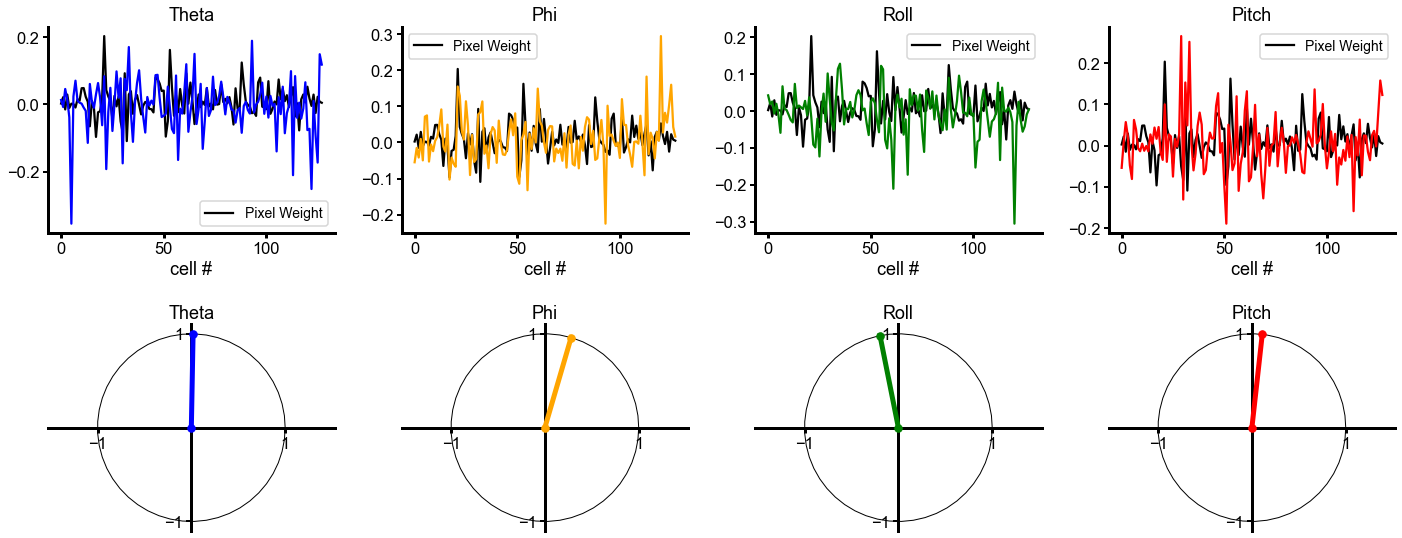

In [196]:
pixn=np.argmax(r2_map_te)
fig, axs = plt.subplots(2,4,figsize=(20,8))
for modeln in range(len(titles)):
    axs[0,modeln].plot(vis_w[pixn],'k')
    axs[0,modeln].plot(move_w[modeln], c=clrs[modeln])
    axs[0,modeln].set_xlabel('cell #')
    axs[0,modeln].set_title(titles[modeln])
    axs[0,modeln].legend(['Pixel Weight'], fontsize=14)

    axs[1,modeln].plot([0,V[pixn,modeln,0]],[0,V[pixn,modeln,1]],'.-',c=clrs[modeln],lw=5, ms=15,zorder=4)
    axs[1,modeln].set(xlim=(-1.1,1.1), ylim=(-1.1,1.1))
    axs[1,modeln].set_title(titles[modeln])
    axs[1,modeln].spines['left'].set_position('center')
    axs[1,modeln].spines['bottom'].set_position('center')
    axs[1,modeln].set_xticks([-1,1])
    axs[1,modeln].set_yticks([-1,1])
    axs[1,modeln].plot(np.cos(np.linspace(0,2*np.pi)), np.sin(np.linspace(0,2*np.pi)), linewidth=1,c='k',zorder=0)
    axs[1,modeln].axis('equal')

plt.tight_layout()
fig.savefig(FigPath/'Cellnum_Vs_Weights.png', facecolor='white', transparent=True, bbox_inches='tight',dpi=300)

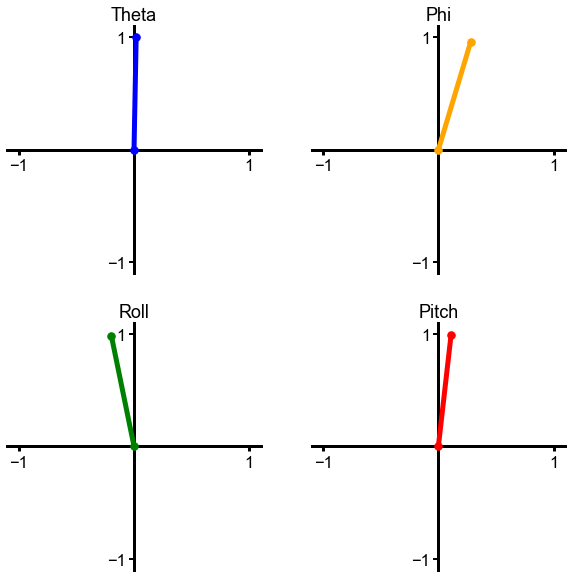

In [111]:
pixn = np.argmax(r2_map_te)
fig, axs = plt.subplots(2,2,figsize=(10,10))
for (ax,modeln) in zip(axs.flat,range(len(titles))):
    # for pixn in np.arange(vis_w.shape[0]):
    ax.plot([0,V[pixn,modeln,0]],[0,V[pixn,modeln,1]],'.-',c=clrs[modeln],lw=5, ms=15,zorder=4)
    ax.set(xlim=(-1.1,1.1), ylim=(-1.1,1.1))
    ax.set_title(titles[modeln])
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.set_xticks([-1,1])
    ax.set_yticks([-1,1])

# fig.savefig(FigPath/'CodingSpace_VisMovAng.png', facecolor='white', transparent=True, bbox_inches='tight',dpi=300)

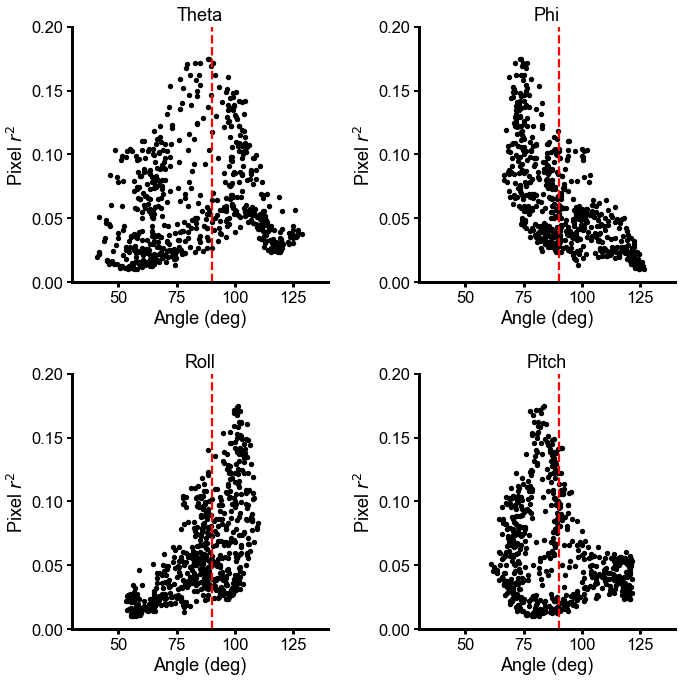

In [162]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
for (ax, modeln) in zip(axs.flat, np.arange(len(titles))):
    ax.scatter(np.rad2deg(move_ang[:,modeln]), r2_map_te, s=15,c='k')
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('Pixel $r^2$')
    ax.set_xlim(30,140)
    ax.set_ylim(0,.2)
    ax.set_title(titles[modeln])
    ax.axvline(x=90,c='r',ls='--')
plt.tight_layout()

fig.savefig(FigPath/'CodingSpace_ang_vs_visr2_scatter.png', facecolor='white', transparent=True, bbox_inches='tight',dpi=300)

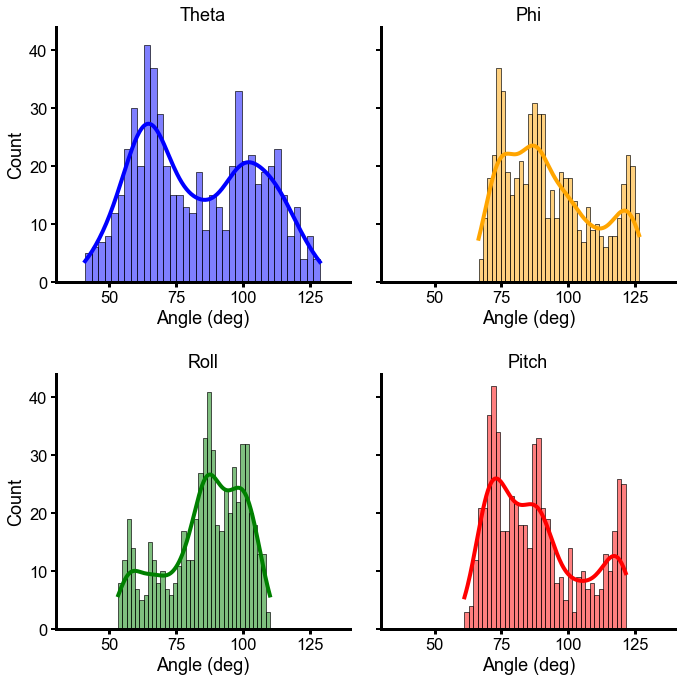

In [105]:
# Density Plot and Histogram of all arrival delays
fig,axs = plt.subplots(2,2,figsize=(10,10),sharey=True)
for (ax, modeln) in zip(axs.flat, np.arange(len(titles))):
    sns.histplot(np.rad2deg(move_ang[:,modeln]), kde=True,
                bins=int(180/5), color=clrs[modeln], fill=True,
                line_kws={'lw':4},ax=ax,
                )
    ax.set_title(titles[modeln])
    ax.set_xlabel('Angle (deg)')
    ax.set_xlim(30,140)
plt.tight_layout()
fig.savefig(FigPath/'CodingSpace_VisMovAng_hist.png', facecolor='white', transparent=True, bbox_inches='tight',dpi=300)

# Pytorch Decoding

In [ ]:
args = arg_parser(jupyter=True)

MovModel = 1
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
# 012821/EE8P6LT
# 128: 070921/J553RT
# '110421/J569LT'# #'062921/G6HCK1ALTRN' '102621/J558NC' '110421/J569LT' #' 110421/J569LT' #
date_ani = args['date_ani'] 
date_ani2 = '_'.join(date_ani.split('/'))
data_dir = Path(args['data_dir']).expanduser() / date_ani / stim_type 
save_dir = (Path(args['save_dir']).expanduser() / date_ani/ stim_type)
save_dir.mkdir(parents=True, exist_ok=True)
save_dir_fm = save_dir.parent /'fm1'
save_dir_hf = save_dir.parent /'hf1_wn'
fig_dir = (Path(args['fig_dir']).expanduser()/'Encoding'/date_ani/stim_type)
fig_dir.mkdir(parents=True, exist_ok=True)
save_model = (save_dir/ 'models' / '{}'.format(MovModel))
save_model.mkdir(parents=True, exist_ok=True)

file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'mapping_json': Path('~/Research/Github/FreelyMovingEphys/probes/channel_maps.json').expanduser(),
            'mp4': True,
            'name': date_ani2 + '_control_Rig2_' + stim_type,  # 070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type == 'hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(), }

params = {
    'Nepochs': args['Nepochs'],
    'model_dt': .05,
    'do_shuffle': False,
    'do_norm': False,
    'do_worldcam_correction': False,
    'lag_list': np.array([-2, -1, 0, 1, 2]),
    'free_move': free_move,
    'save_dir': save_dir,
    'data_dir': data_dir,
    'fig_dir': fig_dir,
    'save_model': save_model,
    'shiftn': 7, 
    'train_shifter': False,
    'MovModel': MovModel,
    'load_Vis' : True if MovModel==2 else False,
    'LinMix': args['LinMix'],
}
params['nt_glm_lag']=len(params['lag_list'])
Nepochs = params['Nepochs']
if params['do_worldcam_correction']:
    params['WC_type'] = 'C'
else:
    params['WC_type'] = 'UC'

data, train_idx, test_idx = load_train_test(file_dict, **params)
locals().update(data)
locals().update(params)

avgfm_eye = ioh5.load(save_dir/'FM_AvgEye_dt{:03d}.h5'.format(int(params['model_dt']*1000)))
if free_move:
    move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['train_phi'][:, np.newaxis]-avgfm_eye['avg_phi'],data['train_roll'][:, np.newaxis], data['train_pitch'][:, np.newaxis]))
    move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['test_phi'][:, np.newaxis]-avgfm_eye['avg_phi'],data['test_roll'][:, np.newaxis], data['test_pitch'][:, np.newaxis]))
    model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['model_phi'][:, np.newaxis]-avgfm_eye['avg_phi'],data['model_roll'][:, np.newaxis], data['model_pitch'][:, np.newaxis]))
else:
    move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['train_phi'][:, np.newaxis]-avgfm_eye['avg_phi'], np.zeros(data['train_phi'].shape)[:, np.newaxis], np.zeros(data['train_phi'].shape)[:, np.newaxis]))
    move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['test_phi'][:, np.newaxis]-avgfm_eye['avg_phi'], np.zeros(data['test_phi'].shape)[:, np.newaxis], np.zeros(data['test_phi'].shape)[:, np.newaxis]))
    model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['model_phi'][:, np.newaxis]-avgfm_eye['avg_phi'], np.zeros(data['model_phi'].shape)[:, np.newaxis], np.zeros(data['model_phi'].shape)[:, np.newaxis]))

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
titles_all = []
for n in range(1, len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

##### Start GLM Parallel Processing #####
nks = np.shape(data['train_vid'])[1:]
nk = nks[0]*nks[1]*params['nt_glm_lag']
perms = np.array(list(itertools.combinations(np.arange(len(titles)), 4)))
# Reshape data (video) into (T*n)xN array
if params['do_worldcam_correction']:
    rolled_vid = np.hstack([np.roll(data['model_vid_sm'], nframes, axis=0) for nframes in params['lag_list']])  
else:
    model_vid_sm_shift = ioh5.load(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1))['model_vid_sm_shift{}'.format(params['shiftn'])]  # [:,5:-5,5:-5]
    nks = np.shape(model_vid_sm_shift)[1:]
    nk = nks[0]*nks[1]*params['nt_glm_lag']
    rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in params['lag_list']])  
if params['train_shifter']:
    x_train = rolled_vid[train_idx] #.reshape(len(train_idx), -1)
    x_test = rolled_vid[test_idx] #.reshape(len(test_idx), -1)
    shift_in_tr = torch.from_numpy(move_train[:, (0, 1, 3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:, (0, 1, 3)].astype(np.float32)).to(device)
else:    
    x_train = rolled_vid[train_idx].reshape(len(train_idx), -1)
    x_test = rolled_vid[test_idx].reshape(len(test_idx), -1)
    shift_in_tr = None
    shift_in_te = None

xtr = torch.from_numpy(data['train_nsp'].astype(np.float32)).to(device)
xte = torch.from_numpy(data['test_nsp'].astype(np.float32)).to(device)

input_size = nk
output_size = ytr.shape[1]

# Reshape data (video) into (T*n)xN array
netparams = {}
if MovModel == 0:
    nk = 0
    mx_train = move_train[:, perms[ind]]
    mx_test = move_test[:, perms[ind]]
    ytr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    yte = torch.from_numpy(mx_test.astype(np.float32)).to(device)
    xtrm = None
    xtem = None
    netparams['move_features'] = None 
    netparams['sta_init'] = None
    netparams['lambdas'] = np.array([None])
    netparams['alphas'] = [None] 
    netparams['lambdas_m'] = None 
    netparams['alphas_m'] = None 
    nlam = len(netparams['lambdas'])
    nalph = len(netparams['alphas'])
    w_move_traces_all = np.zeros((nalph, nlam, params['Nepochs'], output_size, input_size))
elif MovModel == 1:
    xtr = torch.from_numpy(x_train).to(device)
    xte = torch.from_numpy(x_test).to(device)
    xtrm = None
    xtem = None
    netparams['move_features'] = None
    netparams['sta_init'] = torch.zeros((output_size, xtr.shape[-1]))
    netparams['alphas'] = np.array([None])  #.0075
    netparams['lambdas'] = np.hstack((np.logspace(-3, 3.25, 10)[0], np.logspace(-3, 3.25, 20)))
    nlam = len(netparams['lambdas'])
    nalph = len(netparams['alphas'])
    netparams['lambdas_m'] = np.array(nlam*[None])

